# <font color='blue'>Deep Learning II</font>

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

# Prevendo Séries Temporais com Stacked LSTMs 

Finalmente, vejamos um dos maiores benefícios das LSTMs, o fato de que elas podem ser treinadas com sucesso quando empilhadas em arquiteturas de redes profundas. As redes LSTM podem ser empilhadas em Keras da mesma maneira que outros tipos de camada podem ser empilhadas. Uma adição é que a camada LSTM anterior a cada camada LSTM subsequente, deve retornar a sequência. Isso pode ser feito configurando o parâmetro return_sequences = True na camada 1. 

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão do distanciamento social em Minas Gerais.

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
import tensorflow as tf
tf.__version__

C:\Users\Guto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'2.0.0'

In [2]:
import keras as k
k.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
# Imports
import math
import numpy
import pandas as pd
import os
import io
import requests

from pandas.tseries.offsets import DateOffset

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from time import time

In [4]:
# Função Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# Função Carrega os dados
def carrega_dados():
# Carrega os dados
    dataframe = pd.read_csv("./data/AIH.csv")
    dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
    dataframe = dataframe.set_index('Data')

    # Converte dataset em array
    datasetfull = dataframe.values
    datasetfull = datasetfull.astype('float32')
    return datasetfull

In [6]:
# Função Split em treino e teste
def split_train_test(datasetfull):
    train_size = int(len(datasetfull) * 0.75)
    test_size = len(datasetfull) - train_size
    dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]
    return dataset, test

In [7]:
# Função Split em treino e validação
def split_train_test_valid(train_set):
    train_size = int(len(dataset) * 0.67)
    valid_size = len(dataset) - train_size
    train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train, valid 

In [8]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 10

# Cria o objeto scaler no intervalo [0, 1]
# usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))

Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

In [9]:
# Carrega os dados
datasetfull = carrega_dados()

In [10]:
# Split em treino e teste
dataset, test = split_train_test(datasetfull)

In [11]:
# Função Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. 

dataset = scaler.fit_transform(dataset)

In [12]:
# Split em treino e validação
train, valid = split_train_test_valid(dataset)

In [13]:
dataset.shape

(262, 1)

In [14]:
train.shape

(175, 1)

In [15]:
valid.shape

(87, 1)

In [16]:
test.shape

(88, 1)

In [17]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [18]:
# Cria o modelo LSTM
batch_size = 1

model = Sequential()
model.add(LSTM(100, batch_input_shape = (batch_size, look_back, 1), activation = 'relu', return_sequences = True))
model.add(LSTM(50,  activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1))
    
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [21]:
# Cria o modelo LSTM
batch_size = 1

model = Sequential()
model.add(LSTM(200, batch_input_shape = (batch_size, look_back, 1), activation = 'relu', return_sequences = True))
model.add(LSTM(100, activation = 'relu', return_sequences = True))
model.add(LSTM(50,  activation = 'relu', return_sequences = True))
model.add(LSTM(25,  activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
    
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 100)              40800     
_________________________________________________________________
lstm_2 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   1020      
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    21        
Total params: 72,041
Trainable params: 72,041
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (1, 20)                   5680      
_________________________________________________________________
dense_1 (Dense)              (1, 5)                    105       
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    6         
Total params: 16,191
Trainable params: 16,191
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 200)              161600    
_________________________________________________________________
lstm_2 (LSTM)                (1, 10, 100)              120400    
_________________________________________________________________
lstm_3 (LSTM)                (1, 10, 50)               30200     
_________________________________________________________________
lstm_4 (LSTM)                (1, 25)                   7600      
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   520       
_________________________________________________________________
dense_2 (Dense)              (1, 10)                   210       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                   

In [20]:
# Treinamento
start = time()

for i in range(200):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 1, shuffle = False)
    model.reset_states()
    
print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/1
164/164 [==============================] - 6s 35ms/step - loss: 0.0362
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0246
Epoch 1/1
164/164 [==============================] - 5s 32ms/step - loss: 0.0251
Epoch 1/1
164/164 [==============================] - 5s 30ms/step - loss: 0.0255
Epoch 1/1
164/164 [==============================] - 5s 33ms/step - loss: 0.0255
Epoch 1/1
164/164 [==============================] - 5s 31ms/step - loss: 0.0258
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0259
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0257
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0256
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0256
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0255
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0275
Epoch 1/1
164/164 [=========

164/164 [==============================] - 5s 28ms/step - loss: 0.0069
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0069
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0067
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0067
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0068
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0069
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0065
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0067
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0064
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0066
Epoch 1/1
164/164 [==============================] - 5s 29ms/step - loss: 0.0072
Epoch 1/1
164/164 [==============================] - 5s 28ms/step - loss: 0.0083
Epoch 1/1
164/164 [===================

In [23]:
# Treinamento
start = time()

for i in range(5000):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 1, shuffle = False)
    model.reset_states()
    
print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/1
164/164 [==============================] - 11s 66ms/step - loss: 0.0346
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0279
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0290
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0277
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0305
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0311
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0302
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0304
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0304
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0305
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0303
Epoch 1/1
164/164 [========

164/164 [==============================] - 9s 55ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0298
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0297
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291: 0s - loss: 0.029
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [=

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291:
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291:
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 58ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 58ms/step - loss: 0.0291
Epoch 1/1
164/164 [=========

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [=========

Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 58ms/step - loss: 0.0291: 0s - loss: 0.0
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 58ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
16

Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 10s 58ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [========

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 58ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291: 0s - loss:
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 57ms/step - loss: 0.0291
Epoch 1/1
164/164 [=======

164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291: 0s - loss: 0
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 56ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 55ms/step - loss: 0.0291
Epoch 1/1
164/164 [=====

164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [=========

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291: 0s - loss: 0.
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [====

164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 53ms/step - loss: 0.0291
Epoch 1/1
164/164 [==============================] - 9s 54ms/step - loss: 0.0291
Epoch 1/1
164/164 [===================

In [21]:
#trainX

In [22]:
#trainY

In [21]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

## Agora recarregamos o modelo para realizamos uma previsão.

In [22]:
# Carrega os dados
datasetfull = carrega_dados()

# Split em treino e teste
dataset, test = split_train_test(datasetfull)

dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train, valid = split_train_test_valid(dataset)

In [23]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [24]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 100)              40800     
_________________________________________________________________
lstm_2 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   1020      
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    21        
Total params: 72,041
Trainable params: 72,041
Non-trainable params: 0
_________________________________________________________________


In [27]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 200)              161600    
_________________________________________________________________
lstm_2 (LSTM)                (1, 10, 100)              120400    
_________________________________________________________________
lstm_3 (LSTM)                (1, 10, 50)               30200     
_________________________________________________________________
lstm_4 (LSTM)                (1, 25)                   7600      
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   520       
_________________________________________________________________
dense_2 (Dense)              (1, 10)                   210       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                   

In [25]:
# Previsões
batch_size = 1
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)

In [26]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [27]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 2.1682 RMSE
Score em Validação: 4.1827 RMSE


In [30]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 6.3807 RMSE
Score em Validação: 5.7923 RMSE


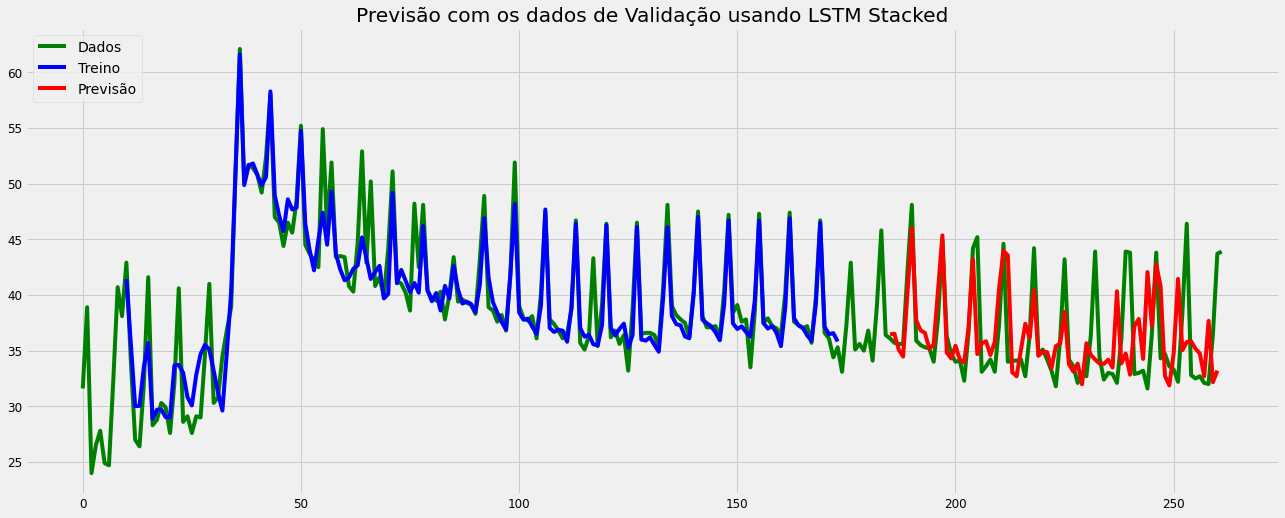

In [28]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Stacked") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Treino')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

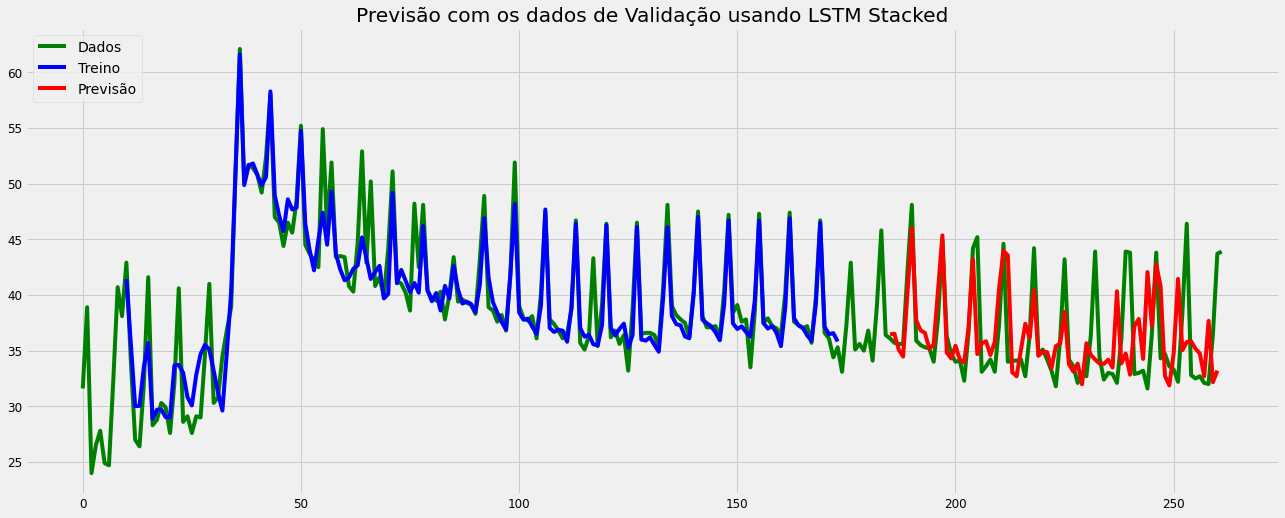

In [29]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Stacked") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Treino')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

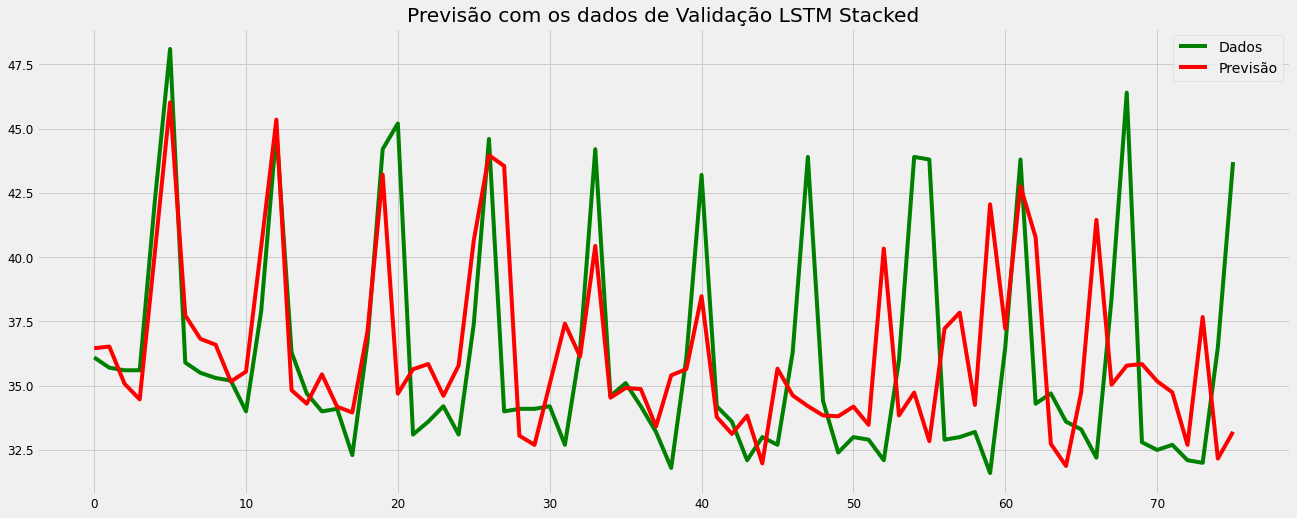

In [30]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Stacked") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

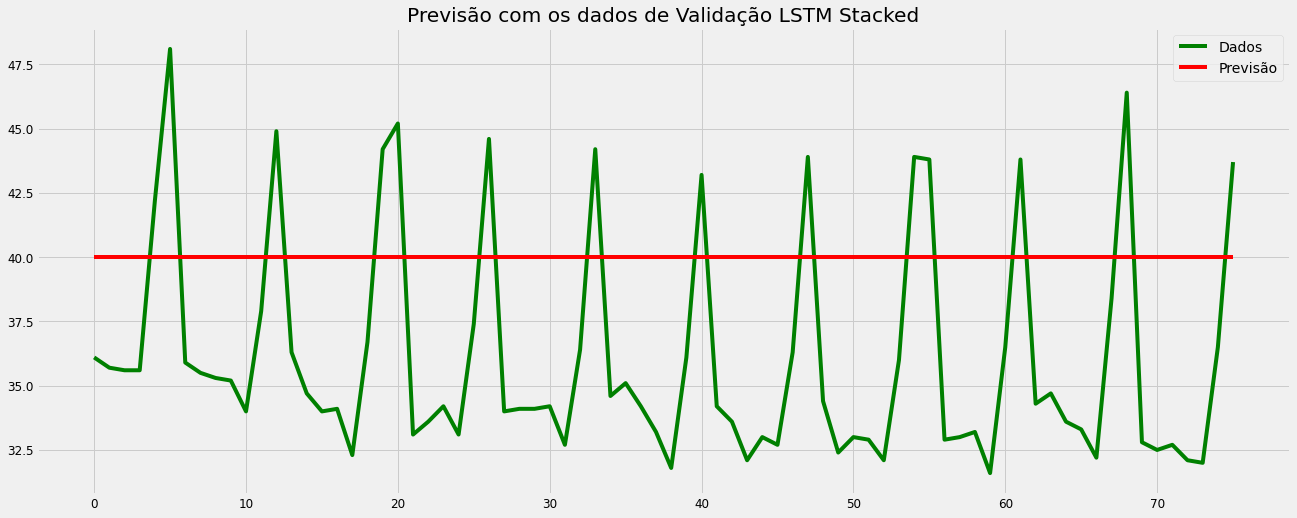

In [34]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Stacked") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Vamos fazer o Forecasting para os dados de teste. 

In [31]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

# Refinamos os dados para o gráfico da série original
# A variável QT_INTER é nossa variável target 
target = dataframe['QT_INTER']
raw_values = target.values

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [32]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 100)              40800     
_________________________________________________________________
lstm_2 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   1020      
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    21        
Total params: 72,041
Trainable params: 72,041
Non-trainable params: 0
_________________________________________________________________


In [37]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 200)              161600    
_________________________________________________________________
lstm_2 (LSTM)                (1, 10, 100)              120400    
_________________________________________________________________
lstm_3 (LSTM)                (1, 10, 50)               30200     
_________________________________________________________________
lstm_4 (LSTM)                (1, 25)                   7600      
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   520       
_________________________________________________________________
dense_2 (Dense)              (1, 10)                   210       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                   

In [33]:
# Previsões com dados de Teste
#model.reset_states()
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

In [34]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [35]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 2.1682 RMSE
Score em Validação: 4.1827 RMSE
Score em Teste: 6.1255 RMSE


In [40]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 6.3807 RMSE
Score em Validação: 5.7923 RMSE
Score em Teste: 5.2433 RMSE


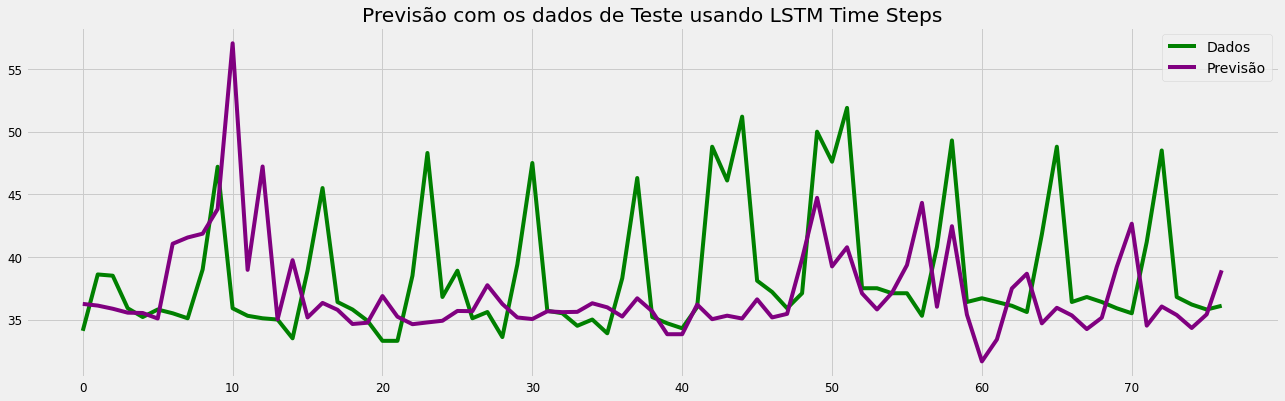

In [36]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Time Steps") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

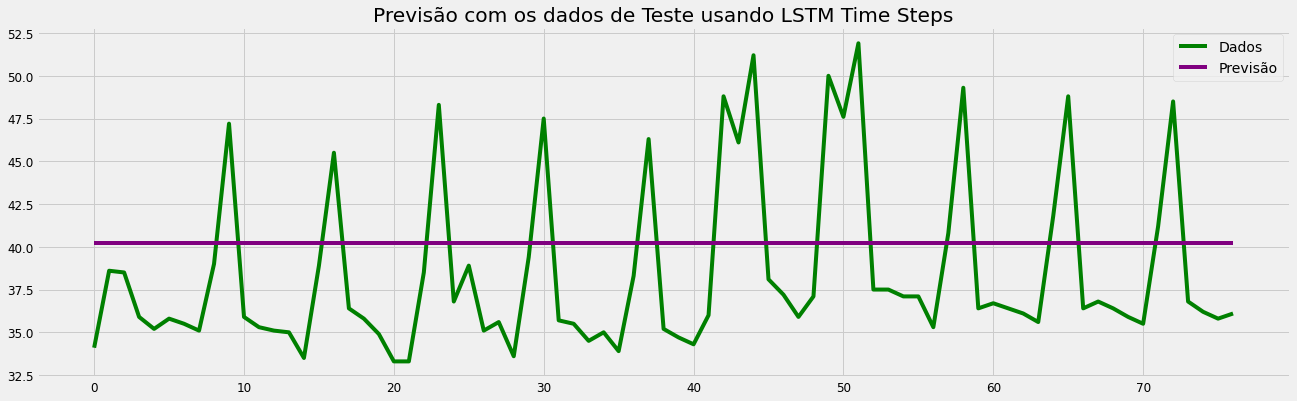

In [42]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Time Steps") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

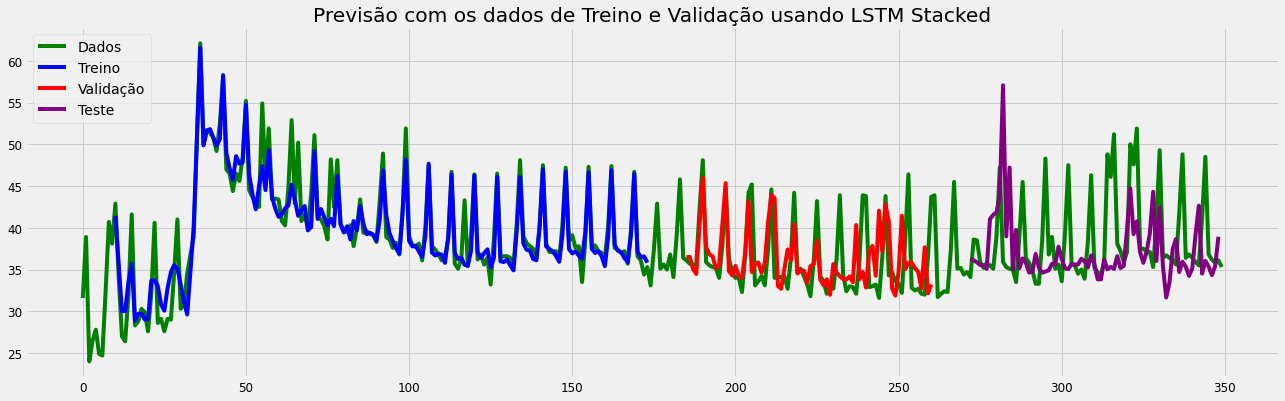

In [37]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict               

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(testPredict)+(look_back*2)+1:len(datasetfull)-1, :] = testPredict
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Stacked") 
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

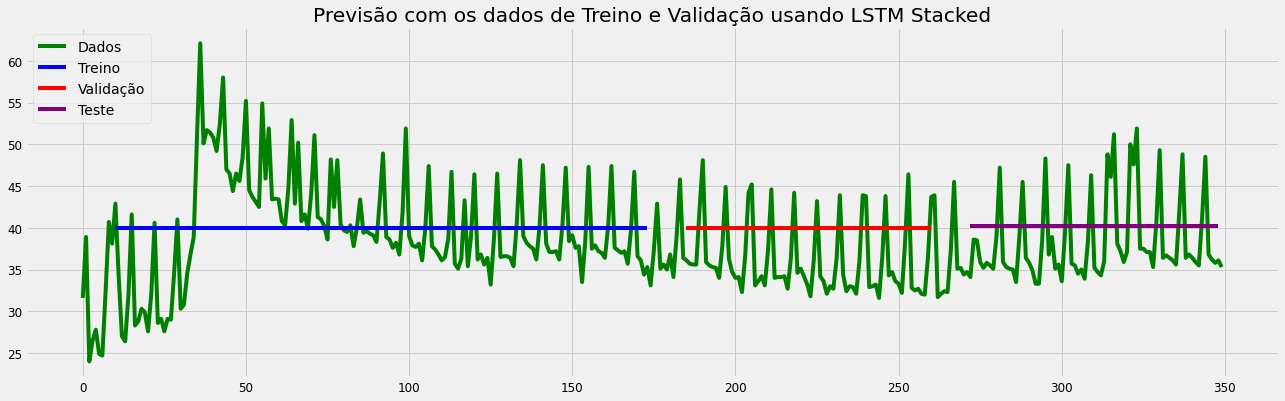

In [44]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict               

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(testPredict)+(look_back*2)+1:len(datasetfull)-1, :] = testPredict
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Stacked") 
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 77 dias de horizonte de previsão

In [38]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

# Refinamos os dados para o gráfico da série original
# A variável QT_INTER é nossa variável target 
target = dataframe['QT_INTER']
raw_values = target.values

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX1, trainY = create_dataset(train, look_back)
validX1, validY = create_dataset(valid, look_back)
testX1, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
validX = numpy.reshape(validX1, (validX1.shape[0], validX1.shape[1], 1))
testX = numpy.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

In [39]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 100)              40800     
_________________________________________________________________
lstm_2 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   1020      
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    21        
Total params: 72,041
Trainable params: 72,041
Non-trainable params: 0
_________________________________________________________________


In [52]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_DIS_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10, 200)              161600    
_________________________________________________________________
lstm_2 (LSTM)                (1, 10, 100)              120400    
_________________________________________________________________
lstm_3 (LSTM)                (1, 10, 50)               30200     
_________________________________________________________________
lstm_4 (LSTM)                (1, 25)                   7600      
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   520       
_________________________________________________________________
dense_2 (Dense)              (1, 10)                   210       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                   

In [40]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, look_back, 1)
    yhat = model.predict(X)
    yhat1 = scaler.inverse_transform(yhat)
    return yhat1[0,0]

In [41]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX1)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX1[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX1) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))
   

Mês = 1, Valor Previsto = 32.579632, Valor Esperado = 42.500000
Mês = 2, Valor Previsto = 32.326473, Valor Esperado = 48.100000
Mês = 3, Valor Previsto = 31.851206, Valor Esperado = 40.400000
Mês = 4, Valor Previsto = 31.258186, Valor Esperado = 39.700000
Mês = 5, Valor Previsto = 31.211641, Valor Esperado = 39.500000
Mês = 6, Valor Previsto = 30.379015, Valor Esperado = 40.300000
Mês = 7, Valor Previsto = 41.639988, Valor Esperado = 37.800000
Mês = 8, Valor Previsto = 42.581501, Valor Esperado = 40.000000
Mês = 9, Valor Previsto = 43.155945, Valor Esperado = 43.400000
Mês = 10, Valor Previsto = 46.866184, Valor Esperado = 39.400000
Mês = 11, Valor Previsto = 71.827995, Valor Esperado = 39.600000
Mês = 12, Valor Previsto = 37.705696, Valor Esperado = 39.300000
Mês = 13, Valor Previsto = 53.273624, Valor Esperado = 39.100000
Mês = 14, Valor Previsto = 30.245901, Valor Esperado = 38.300000
Mês = 15, Valor Previsto = 39.170097, Valor Esperado = 43.200000
Mês = 16, Valor Previsto = 30.5353

In [42]:
previsoes_lstm

[32.57963,
 32.326473,
 31.851206,
 31.258186,
 31.211641,
 30.379015,
 41.639988,
 42.5815,
 43.155945,
 46.866184,
 71.827995,
 37.705696,
 53.273624,
 30.245901,
 39.170097,
 30.535378,
 32.72858,
 31.68713,
 29.553108,
 29.74668,
 33.76659,
 30.648554,
 29.522083,
 29.791626,
 30.04008,
 31.517933,
 31.483618,
 35.395725,
 32.56606,
 30.533121,
 30.30034,
 31.469488,
 31.33939,
 31.3812,
 32.676266,
 32.0597,
 30.675344,
 33.423336,
 31.460697,
 28.014328,
 28.014277,
 32.482872,
 30.281197,
 30.805658,
 30.375835,
 33.2659,
 30.541336,
 31.07753,
 39.35417,
 48.555603,
 38.224358,
 41.10609,
 34.16754,
 31.746574,
 34.24762,
 38.430946,
 47.79652,
 32.155937,
 44.2794,
 30.963467,
 23.921143,
 27.22662,
 34.91041,
 37.12713,
 29.653543,
 31.992178,
 30.84701,
 28.78952,
 30.504223,
 38.150585,
 44.659897,
 29.306028,
 32.18697,
 30.906786,
 28.952383,
 31.004303,
 37.63192]

In [43]:
# Última data da série
target.index[-1]

Timestamp('2021-01-29 00:00:00')

In [44]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 78)]

In [49]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [51]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [52]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,QT_INTER
2021-01-30,NaN
2021-01-31,NaN
2021-02-01,NaN
2021-02-02,NaN
2021-02-03,NaN
...,...
2021-04-12,NaN
2021-04-13,NaN
2021-04-14,NaN
2021-04-15,NaN


In [53]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [54]:
df_predict

,Prediction
2021-01-30,36.248783
2021-01-31,36.114559
2021-02-01,35.862583
2021-02-02,35.548172
2021-02-03,35.523495
...,...
2021-04-12,36.040600
2021-04-13,35.361866
2021-04-14,34.325672
2021-04-15,35.413570


In [56]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [57]:
# Visualiza o dataframe
df_forecasting

,QT_INTER,Prediction
2020-02-15,31.6,NaN
2020-02-16,38.9,NaN
2020-02-17,24.0,NaN
2020-02-18,26.5,NaN
2020-02-19,27.8,NaN
...,...,...
2021-04-12,NaN,36.040600
2021-04-13,NaN,35.361866
2021-04-14,NaN,34.325672
2021-04-15,NaN,35.413570


In [58]:
df_forecasting.to_csv(r'./data/AIHForecastingStacked.csv', index = False)

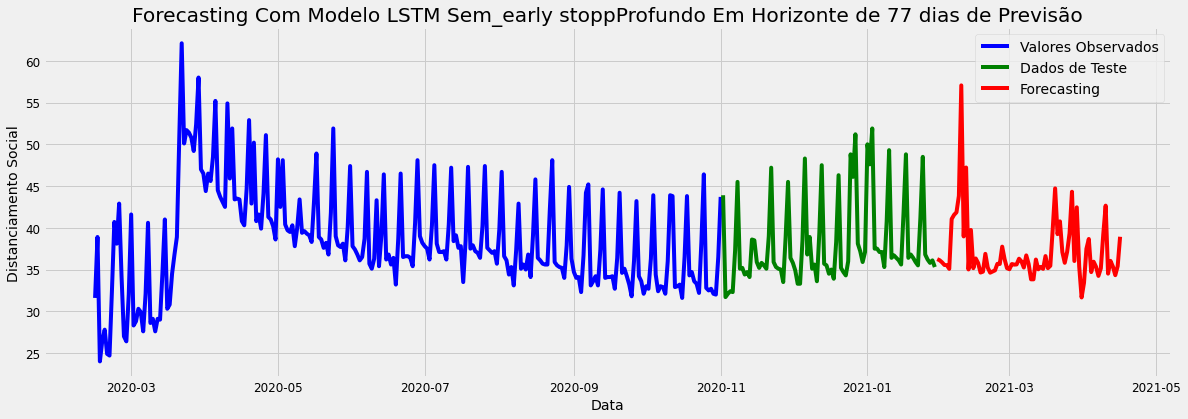

In [59]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:261], target.values[0:261], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[261:], target.values[261:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Sem_early stoppProfundo Em Horizonte de 77 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

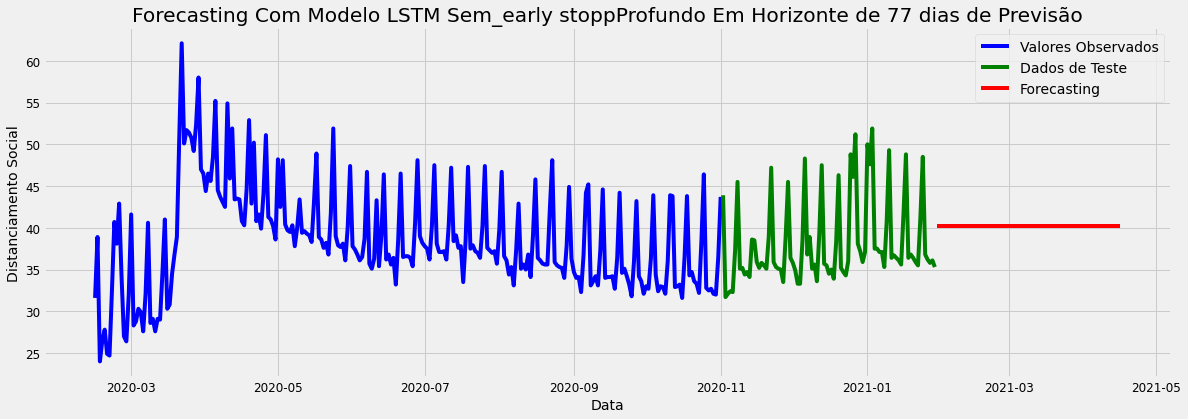

In [87]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:261], target.values[0:261], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[261:], target.values[261:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Sem_early stoppProfundo Em Horizonte de 77 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim